## 13. 인공지능으로 세상에 없던 새로운 패션 만들기

#### 0. 작업환경 구성하기

In [26]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

#### 1. 데이터셋 구성하기

In [27]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [29]:
train_no = train_x
print(f"MAX : {train_x.max()}, MIN : {train_x.min()}")
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1,1]로 정규화
print(f"MAX : {train_x.max()}, MIN : {train_x.min()}")
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

MAX : 255, MIN : 0
MAX : 1.0, MIN : -1.0


(50000, 32, 32, 3)

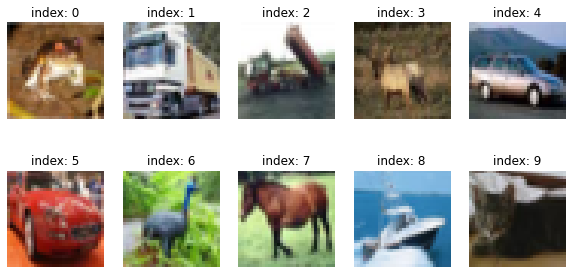

In [30]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_no[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

- Clipping input data to the valid range for imshow with RGB data
- ([0..1] for floats or [0..255] for integers).라는 오류가 생기는데
- plt.imshow((train_x[i]*255).astype(np.uint8), cmap='gray') 로 해결은 가능하다


#### 2. 생성자 모델 구현하기

In [31]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [32]:
def make_generator_model():
    #시작
    model = tf.keras.Sequential()

    # 첫번째 Dense layer
    model.add(layers.Dense(8*8*256, use_bias = False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 두번째 Reshape layer
    model.add(layers.Reshape((8,8,256)))

    # 세번째 Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128,kernel_size=(5,5),strides=(1,1),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 추가 레이어 생성
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    # 네번째 Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64,kernel_size=(5,5),strides=(2,2),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 다섯번째 Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3,kernel_size=(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))

    return model

#### 3. 판별자 모델 구현하기

In [33]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_4 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)        

In [34]:
def make_discriminator_model():

    # 시작 모델 정의
    model = tf.keras.Sequential()
    # 첫번째 : Conv2D Layer
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[32,32,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # 두번째 : Conv2D Layer
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # 추가
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # 추가
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # 세번째 : Flatten Layer
    model.add(layers.Flatten())
    # 네번째 Dense Layer
    model.add(layers.Dense(1))
    return model

In [35]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)        

In [36]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### 4. 손실함수와 최적화 함수 구현하기

In [37]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### 5. 훈련과정 상세 기능 구현하기

In [39]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate,noise_dim])
seed.shape

TensorShape([16, 100])

In [40]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [41]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False) # 결과값이 나오는 부분

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        temp_invcal = predictions.numpy()
        temp_invcal = (temp_invcal * 127.5) + 127.5 # [0, 255]로 스케일링(역산)
        temp_invcal = temp_invcal.astype(int)
        plt.subplot(4, 4, i+1)
        plt.imshow(temp_invcal[i]) # 역산한 값 넣기
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [42]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()


In [43]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### 6. 학습 과정 진행하기

In [44]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [45]:
save_every = 5
EPOCHS = 100

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

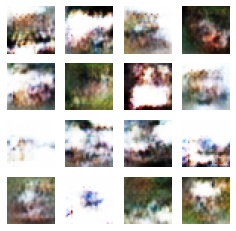

Time for training : 4803 sec


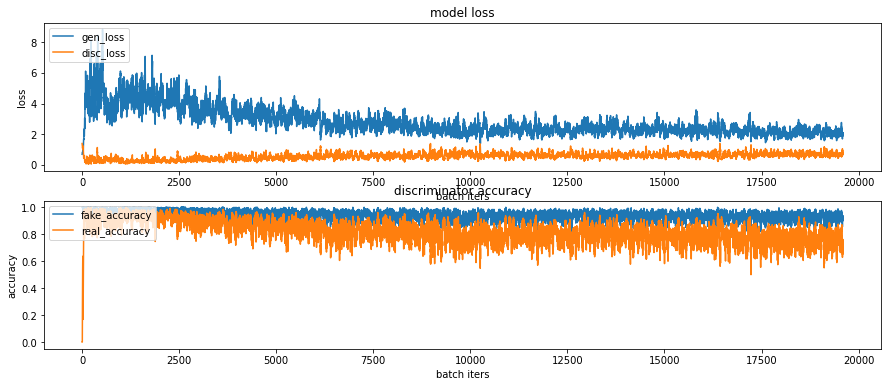

CPU times: user 59min 47s, sys: 20min 35s, total: 1h 20min 23s
Wall time: 1h 20min 5s


In [46]:
%%time
train(train_dataset,EPOCHS,save_every)

In [47]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif
11
1

-rw-r--r-- 1 root root 1801512 Nov 15 04:31 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


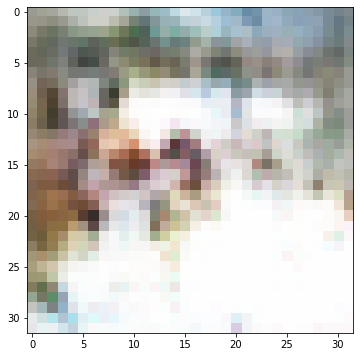

In [48]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다.
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

### 7. GAN 훈련 과정 개선하기

* 1차 시도
   * 노드에 올라가있는 코드를 그대로 실행하다보니 28*28*1 배열이 32*32*3과는 맞지 않아서 결과값이 좋지 않았다
* 2차 시도
   * 32*32로 바꾸고 레이어를 추가하였다. 전보다 이미지가 개선된 것 같았다.
* 3차 시도
   * epochs : 50 -> 100
   * 훈련값이 적은것같아보여서 100까지 올려보았다.



#### 회고
- GAN을 처음 다뤄봤는데 조금 공부하고싶은 생각이 들었습니다. 데이터를 직접 생성하여 대조한다는 것도 새롭고 좋았던 것같습니다.
